In [238]:
# 初始化参数
import librosa


n_fft = 256
hop_length = 16
win_length = 256
Fs = 16000
# 设置待降噪路径
noisy_path = "TestData\mixed_0dB.wav"
noisy, _ = librosa.load(noisy_path, sr=Fs)

In [239]:
import torch
from DeepFIR_RKNN.DeepFIR_RKNN import LstmWin
from util.utils import prepare_device
# 加载检查点
Tar_Path = 'DeepFIR_RKNN\\best_model.tar'
model_checkpoint = torch.load(Tar_Path, weights_only=False)  # 现在不会报错
model_static_dict = model_checkpoint["model"]
# 实例化模型（需确保参数与训练时一致）
model = LstmWin()  # 替换为你的实际参数
model.load_state_dict(model_static_dict)  # 加载参数

# 选择设备
device = prepare_device(torch.cuda.device_count())
model.to(device)
model.eval()

LstmWin(
  (lstm_layer_1): LSTM(129, 200, batch_first=True)
  (lstm_layer_2): LSTM(200, 200, batch_first=True)
  (fc_layer): Sequential(
    (0): Linear(in_features=200, out_features=129, bias=True)
    (1): ReLU()
    (2): Linear(in_features=129, out_features=129, bias=True)
    (3): Sigmoid()
  )
)

In [240]:
# 切割 noisy_mag 和 clean_mag
def split_frames(magnitude,Block_Num):
    batches = []
    T = magnitude.shape[1]
    # 确保 T 可以被 4 整除，否则丢弃多余的帧
    T_cut = T // Block_Num * Block_Num # 取 T 中可以被 4 整除的部分
    magnitude = magnitude[:, :T_cut]
    # 按每 4 帧切割
    num_segments = T_cut // Block_Num  # 计算可以切割成多少段
    noisy_mag_segments = magnitude[:, :T_cut].reshape(magnitude.shape[0], num_segments, Block_Num)  # (F, num_segments, 16)
    # 将每个块添加到 batches 列表中
    for chunk in noisy_mag_segments.transpose(1, 0, 2):  # 形状 (num_chunks, F, 16)
        # 转换为 PyTorch 张量
        batch_tensor = torch.tensor(chunk, dtype=torch.float32)
        batches.append(batch_tensor)
    stacked_batches = torch.stack(batches[:], dim=0)
    return stacked_batches

In [241]:
noisy_mag, noisy_phase = librosa.magphase(librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
noisy_blocks = split_frames(noisy_mag,16) # 进行拆分
noisy_mag = torch.tensor(noisy_blocks, device=device).unsqueeze(1)   # [B, F, T] => [B, 1, F, T]
noisy_blocks = torch.tensor(noisy_blocks, device=device)

enhanced_FIR_Taps = model(noisy_mag)
enhanced_mag = noisy_blocks * enhanced_FIR_Taps

enhanced_mag = enhanced_mag.transpose(0, 1).flatten(1).detach().cpu().numpy() # [F, T]
noisy_phase = noisy_phase[:,:enhanced_mag.shape[1]]
enhanced = librosa.istft(enhanced_mag * noisy_phase, hop_length=hop_length, win_length=win_length)

C:\Users\96273\AppData\Local\Temp\ipykernel_30952\1060604775.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_mag = torch.tensor(noisy_blocks, device=device).unsqueeze(1)   # [B, F, T] => [B, 1, F, T]
C:\Users\96273\AppData\Local\Temp\ipykernel_30952\1060604775.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_blocks = torch.tensor(noisy_blocks, device=device)


In [242]:
# # 用自带逆变换回复
# enhanced = librosa.istft(enhanced_mag * noisy_phase, hop_length=hop_length, win_length=win_length, length=len(noisy))

In [243]:
# # 尝试1.直接每一帧逆变换并且除了第一帧其余帧只留下最后hop_length长度的时域数据（发现直接以这种方式会导致无法完美重建信号）
# # 将幅度谱和相位谱组合为复数频谱
# import numpy as np
# D = enhanced_mag * noisy_phase
# # 1. 对每一帧进行逆FFT
# frames = np.fft.irfft(D, n=n_fft, axis=0)  # 逆FFT，得到时域帧
# # 2. 处理时域帧
# processed_frames = []
# for i in range(frames.shape[1]):  # 遍历每一帧
#     if i == 0:
#         # 保留第一帧的全部数据
#         processed_frames.append(frames[:, i])
#     else:
#         # 只保留最后 hop_length 长度的数据
#         processed_frames.append(frames[-hop_length:, i])
# # 3. 重叠相加重构信号
# enhanced = np.zeros(hop_length * (len(processed_frames) - 1) + len(processed_frames[0]))
# for i, frame in enumerate(processed_frames):
#     start = i * hop_length
#     end = start + len(frame)
#     enhanced[start:end] += frame

In [244]:
# # 尝试2.直接IFFT后用矩形窗合并（效果很不错）
# # 将幅度谱和相位谱组合为复数频谱
# import numpy as np
# import librosa
# D = enhanced_mag * noisy_phase
# # 1. 对每一帧进行逆FFT
# frames = np.fft.irfft(D, n=n_fft, axis=0)  # 逆FFT，得到时域帧
# frames = frames
# # 2. 处理时域帧
# processed_frames = []
# for i in range(frames.shape[1]):  # 遍历每一帧
#     processed_frames.append(frames[:, i])
# # 3. 重叠相加重构信号
# enhanced = np.zeros(hop_length * (len(processed_frames) - 1) + len(processed_frames[0]))
# for i, frame in enumerate(processed_frames):
#     start = i * hop_length
#     end = start + len(frame)
#     enhanced[start:end] += frame


In [245]:
# 画图展示
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as ipd
def Plot_AudioData(enhanced,title,Fs):
    enhanced_mag, _ = librosa.magphase(librosa.stft(enhanced, n_fft=320, hop_length=160, win_length=320))
    # 转换为分贝（dB）尺度
    enhanced_mag_db = librosa.amplitude_to_db(enhanced_mag, ref=20)
    # 绘制时频图
    plt.figure(figsize=(13, 5))
    librosa.display.specshow(enhanced_mag_db, sr=Fs, hop_length=160, x_axis='time', y_axis='linear', cmap='magma')
    # 添加颜色条
    plt.colorbar(format='%+2.0f dB')
    # 设置标题和标签
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # 显示图像
    plt.show()
    plt.figure(figsize=(13, 5))
    plt.plot(enhanced)
    plt.title("Time")
    plt.show()
    # 显示音频播放
    ipd.display(ipd.Audio(enhanced, rate=Fs))

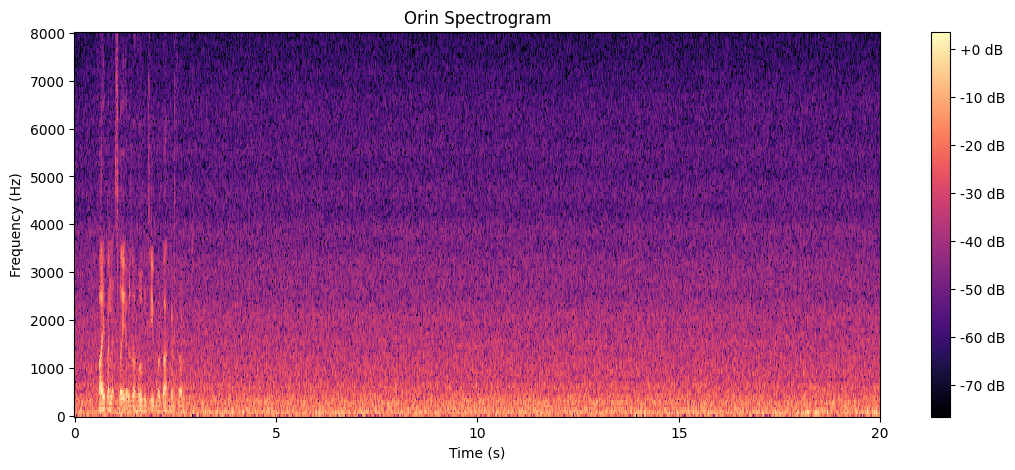

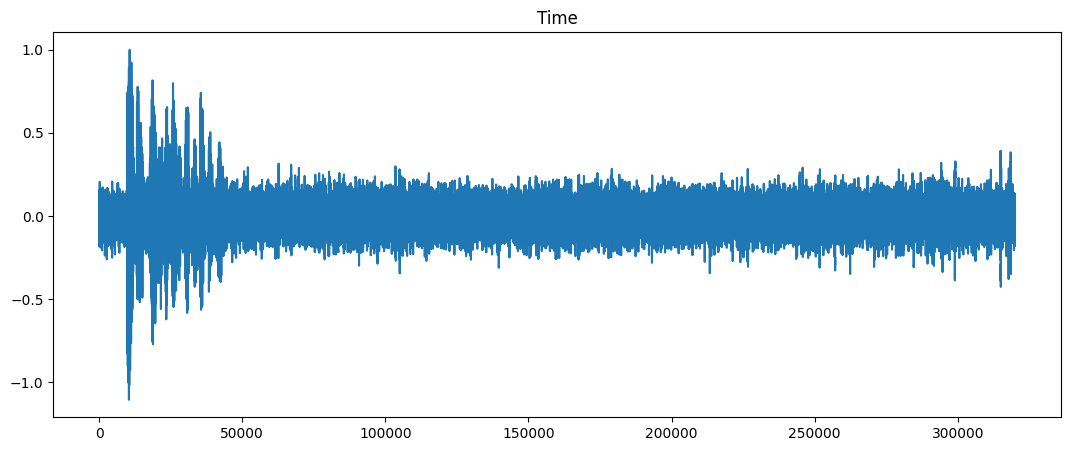

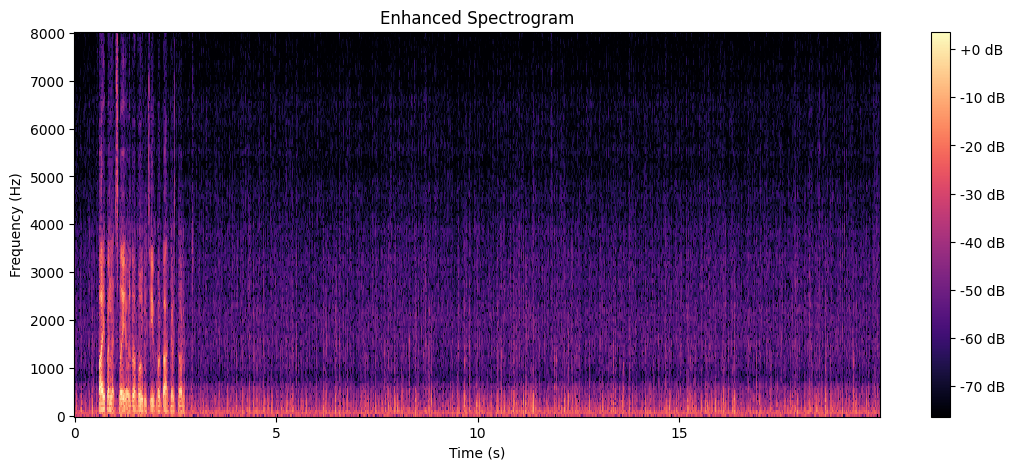

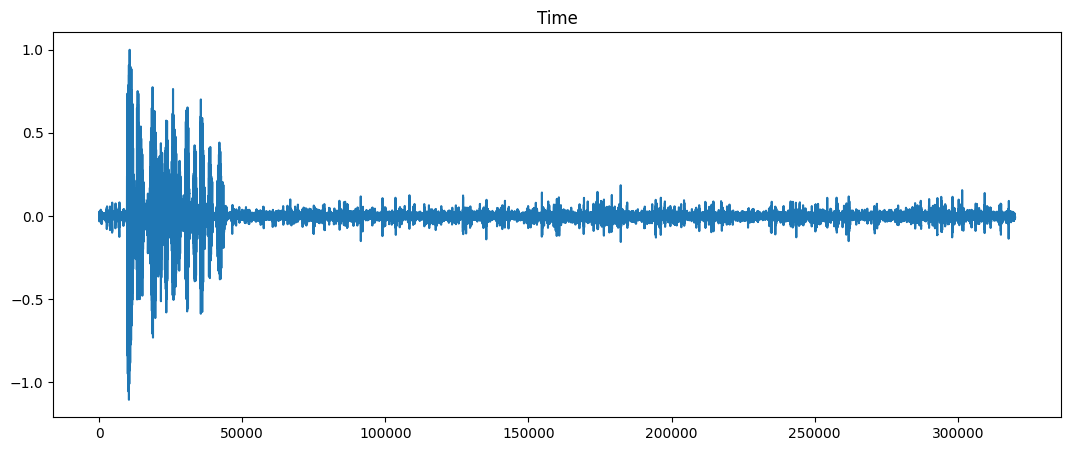

In [246]:
# 先画出原始音频
noisy = noisy/max(noisy)
Plot_AudioData(noisy,'Orin Spectrogram',Fs)
# 再画出增强音频
enhanced = enhanced/max(enhanced)
Plot_AudioData(enhanced,'Enhanced Spectrogram',Fs)